# Analyze diameter along the dendritic tree

In [36]:
import sys, os

import pandas
import numpy as np
from scipy import stats

sys.path.append('../neural_network_dynamics/')
import nrn # my layer to read and process swc files
from nrn.plot import nrnvyz # visualize neuronal morphologies

# data visualization
sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt

# (optional) we disable numpy warning -- the RuntimeWarning that comes with np.nanmean 
import warnings
warnings.filterwarnings("ignore")

# color code:
colors = {'BC':'tab:red', 'MC':'tab:orange'}

## 1) Load and build dataset

In [4]:
datafolder = '../data/SchneiderMizell_et_al_2023'
DATASET = {}

for key in os.listdir(datafolder):
    if 'csv' in key:
        DATASET[key.replace('.csv', '')] = pandas.read_csv('../data/SchneiderMizell_et_al_2023/%s' % key)
        
# ID of the two cell types of interest:
for cType in ['MC', 'BC']:
    DATASET['%s_id' % cType] = DATASET['cell_types']['pt_root_id'][DATASET['cell_types']['cell_type_manual']==cType]

## 2) Loop over cells and compute distance-diameter relationship

In [33]:
bins = np.linspace(40, 300, 20) # DIAMETER RANGE analyzed

DIAMETERS = {}
for cType in ['BC', 'MC']:
    
    DIAMETERS[cType] = -1*np.ones((len(DATASET['%s_id' % cType]), len(bins))) # -1 as a flag for None
    for i, ID in enumerate(DATASET['%s_id' % cType]):
        
        morpho = nrn.Morphology.from_swc_file(os.path.join(datafolder,
                                                           'skeletons', '_fixed', '%s.swc'%ID))
        SEGMENTS = nrn.morpho_analysis.compute_segments(morpho)

        # discard axon and soma in morphology analysis
        cond = (SEGMENTS['comp_type']!='axon') & (SEGMENTS['comp_type']!='soma')
        
        i_bins = np.digitize(1e6*SEGMENTS['distance_to_soma'][cond], bins=bins)
        
        for k, b in enumerate(bins):
            b_cond = (i_bins==k)
            if np.sum(b_cond)>1:
                DIAMETERS[cType][i,k] = np.mean(1e6*SEGMENTS['diameter'][cond][b_cond])
       
    DIAMETERS[cType][DIAMETERS[cType]==-1] = np.nan # replace -1 with np.nan

## 3) Plot

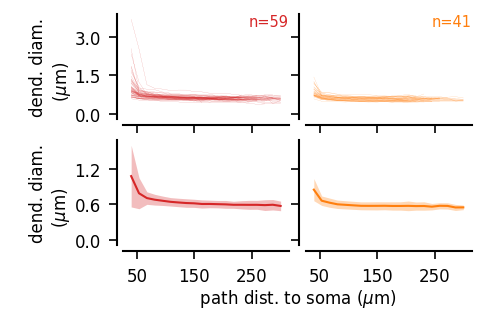

In [49]:
fig, AX = plt.subplots(2, 2, figsize=(3,2))
plt.subplots_adjust(wspace=0.1)

for c, cType in enumerate(['BC', 'MC']):

    for i, ID in enumerate(DATASET['%s_id' % cType]):
        plot_cond = (DIAMETERS[cType][i,:]>0)
        AX[0][c].plot(bins[plot_cond], DIAMETERS[cType][i,plot_cond], color=colors[cType], lw=0.05)
        
    AX[0][c].annotate('n=%i' % DIAMETERS[cType].shape[0], (1,1), xycoords='axes fraction',
                va='top', ha='right', color=colors[cType], fontsize=7)
    
    pt.plot(bins, 
            np.nanmean(DIAMETERS[cType], axis=0), 
            sy=np.nanstd(DIAMETERS[cType], axis=0), 
            color=colors[cType], ax=AX[1][c])
    
        
for i in range(2):
    AX[i][0].plot([50], [0], 'w.', ms=0.01)
    pt.set_plot(AX[i][0], xticks=50+np.arange(3)*100,
                ylabel='dend. diam.\n($\mu$m)      ', xlabel=35*' '+'path dist. to soma ($\mu$m)' if i==1 else '')
    pt.set_plot(AX[i][1], xticks=50+np.arange(3)*100, yticks_labels=[])
    pt.set_common_ylims(AX[i])
    
fig.savefig('../figures/diameters_along_tree_all.svg')

## 4) Make stats on different bins

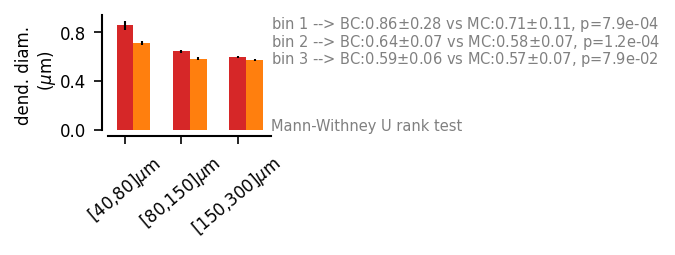

In [71]:
BINS = np.array([40, 80, 150, 300])

from itertools import product

fig, ax = plt.subplots(1, figsize=(1.4,1))

VALUES = {}
for c, cType in zip(range(2), ['BC', 'MC']):
    VALUES[cType] = []
    for k, (x1, x2) in enumerate(zip(BINS[:-1], BINS[1:])):
        values = []
        for i, ID in enumerate(DATASET['%s_id' % cType]):
            cond = (bins>=x1) & (bins<x2)
            values.append(np.nanmean(DIAMETERS[cType][i,:][cond]))
        ax.bar([k+c*0.3], [np.mean(values)],
               yerr=[stats.sem(values)], color=colors[cType], width=0.3)

        VALUES[cType].append(values)
        
# statistical analysis : unpaired comparison --> Mann-Withney
ax.annotate('Mann-Withney U rank test',
            (1, 0), color='grey', xycoords='axes fraction', fontsize=7)
i=0
for b in range(3):
    ax.annotate(i*'\n'+'bin %i --> BC:%.2f$\pm$%.2f vs MC:%.2f$\pm$%.2f, p=%.1e' % (i+1, \
                                    np.mean(VALUES['BC'][i]), np.std(VALUES['BC'][i]),
                                    np.mean(VALUES['MC'][i]), np.std(VALUES['MC'][i]),
                      stats.mannwhitneyu(VALUES['BC'][i], VALUES['MC'][i]).pvalue),
                (1,1), color='grey', va='top', xycoords='axes fraction', fontsize=7)

    i+=1
    
XTICKS = ['[%i,%i]$\mu$m ' % (x1, x2) for x1, x2 in zip(BINS[:-1], BINS[1:])]
pt.set_plot(ax, ylabel='dend. diam. \n ($\mu$m)',
            xticks=range(3), xticks_labels=XTICKS, xticks_rotation=40)

fig.savefig('../figures/diameters_along_tree_stats.svg')